In [1]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import math
import pickle

from numpy.random import seed
from tensorflow import random

In [2]:
DATA_DIR2 = './data8/'
ids = os.listdir(DATA_DIR2)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR2, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                path = os.path.join(DATA_DIR2, 'images', imgFile)
                throttle = jsonObj['user/throttle']
                if throttle != 0.0 and os.path.exists(path) :
                    image = cv2.imread(path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                    #image = image[65:200, :]
                    #image = cv2.resize(image, (60,35))
                    image = cv2.resize(image, None, fx=0.50, fy= 0.50)
                    #image = cv2.resize(image, (60,60))
                    jsonObj['image'] = image
                    pvm_angels.append(jsonObj)


In [3]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
     A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),
])

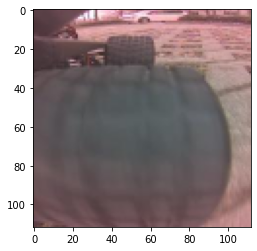

(112, 112, 3)

In [4]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

In [5]:
#prepare and split data



df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])
idxs = np.array(df['_index'])

#images = images[4:] 
#pwms = pwms[:-4]

angs = list(zip(images, pwms, idxs))
rnd.shuffle(angs)
images, pwms, idxs = zip(*angs)
images = np.array(images) 
pwms = np.array(pwms)
idxs = np.array(idxs)

trainImagesX, testImagesX, trainPwmsX, testPwmsX = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImagesX, valImagesX, trainPwmsX, valPwmsX = train_test_split(trainImagesX, trainPwmsX, test_size=0.135, random_state=42)


In [6]:
#implment augmentation 
augmentedTrainImages = []
for i in range(len(trainImagesX)):
    orig_image = trainImagesX[i]
    augmentedTrainImages.append(orig_image)
    for j in range(9):
        augmentedTrainImages.append(transform(image=orig_image)['image'])

augmentedTrainImages = np.array(augmentedTrainImages)        
augmentedPwms = np.array(trainPwmsX).repeat(10)

augmentedTrainImages.shape, augmentedPwms.shape

((63820, 112, 112, 3), (63820,))

#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_d8_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

# Usage

In [7]:
def calc_ackerman(pwms):
    L = 178 #wheelbase
    b = 165 #

    theta = pwms
    R = L/(np.tan(np.radians(theta))+0.0000001)
    tg_alpha = L/(R+np.sign(theta)*b*25)
    alpha = np.degrees(np.arctan(tg_alpha))

    return alpha

def conv_sigmoid(pwms):
    return (pwms+1)/2.0

#LOAD DATA
with open('car_aug_data_25_vgg.pickle', 'rb') as f:
    data = pickle.load(f)
(augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX) = data


augmentedPwms = calc_ackerman(augmentedPwms)
valPwmsX = calc_ackerman(valPwmsX)
testPwmsX = calc_ackerman(testPwmsX)




In [8]:
augmentedPwms = conv_sigmoid(augmentedPwms)
valPwmsX = conv_sigmoid(valPwmsX)
testPwmsX = conv_sigmoid(testPwmsX)

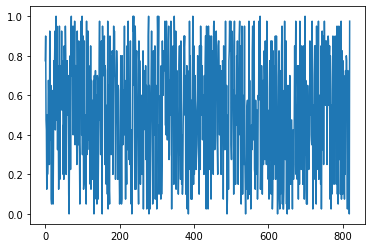

In [9]:
plt.plot(testPwmsX)

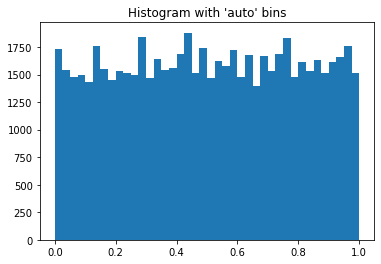

In [10]:
_ = plt.hist(augmentedPwms, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [11]:
seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

input_shape = augmentedTrainImages[0].shape

model = tf.keras.applications.VGG16(
weights='imagenet',
input_shape=input_shape,
include_top=False
)

for layer in model.layers:
      layer.trainable = False
        
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model.input, outputs=x)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImagesX, valPwmsX), epochs=50)

2022-12-15 18:23:28.695545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Epoch 1/50
1995/1995 [==============================] - 28s 12ms/step - loss: 0.0121 - val_loss: 0.0046
Epoch 2/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 3/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 4/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 5/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 6/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 7/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 8/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 9/50
1995/1995 [==============================] - 25s 12ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 10/50
1995/1995 [==============================] - 25s 12m

In [12]:
model.save('50_vgg_d8_move_no4.model')

INFO:tensorflow:Assets written to: 50_vgg_d8_move_no4.model/assets


INFO:tensorflow:Assets written to: 50_vgg_d8_move_no4.model/assets


In [13]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_50_vgg_no4.pickle', 'wb') as f:
    pickle.dump(data, f )

import  tensorflow.keras.models
model = tensorflow.keras.models.load_model('25_vgg_d8_move.model')

In [14]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score)


Test loss: 0.0035355009604245424


In [15]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 12, 15, 18, 44, 41, 940638)

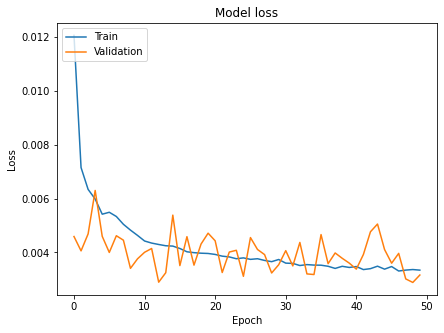

In [16]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [17]:
def show_pwm_prediction3(pwms, preditions, text, start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))    
    
    angs = list(zip(pwms.copy(), preditions))
    res = sorted(angs, key = lambda x: x[0])
    pwms, preditions  = zip(*res)
    
    data = zip()
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

          
    ax.plot(idxs, preditions, 'o', color="blue")
    ax.plot(idxs, pwms, 'o', color="green")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
    #print(pwms[5000], pwms[10000], pwms[15000],pwms[20000], pwms[25000], pwms[30000])
    #print(preditions[5000], preditions[10000], preditions[15000],preditions[20000], preditions[25000], preditions[30000])
    
    

26/26 [==============================] - 0s 11ms/step


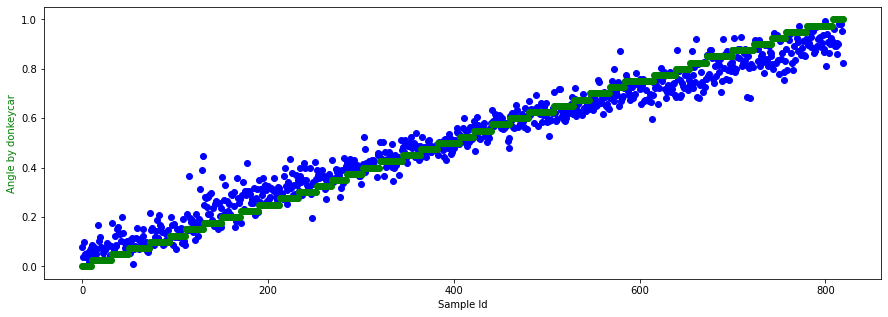

Sample count:  820
SSE 102308.29117323626


In [29]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX)
predictions2 = np.array(predictions)
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [19]:
residuals = abs(predictions.flatten() - testPwmsX)

In [21]:
residuals.min(),residuals.max(),residuals.mean(), np.median(residuals), np.std(residuals)


(0.00018554925918601306,
 0.2961300373077391,
 0.04614872275510944,
 0.03806109279394143,
 0.03749394752172974)

In [22]:
a = list(zip(testPwmsX, predictions, residuals))


(array([83., 99., 74., 63., 78., 69., 59., 54., 41., 40., 40., 23., 22.,
        18., 13.,  8.,  8.,  3.,  3.,  5.,  4.,  4.,  2.,  0.,  1.,  2.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([1.85549259e-04, 7.58416146e-03, 1.49827737e-02, 2.23813859e-02,
        2.97799981e-02, 3.71786103e-02, 4.45772225e-02, 5.19758347e-02,
        5.93744469e-02, 6.67730591e-02, 7.41716713e-02, 8.15702835e-02,
        8.89688957e-02, 9.63675079e-02, 1.03766120e-01, 1.11164732e-01,
        1.18563344e-01, 1.25961957e-01, 1.33360569e-01, 1.40759181e-01,
        1.48157793e-01, 1.55556405e-01, 1.62955018e-01, 1.70353630e-01,
        1.77752242e-01, 1.85150854e-01, 1.92549466e-01, 1.99948079e-01,
        2.07346691e-01, 2.14745303e-01, 2.22143915e-01, 2.29542527e-01,
        2.36941140e-01, 2.44339752e-01, 2.51738364e-01, 2.59136976e-01,
        2.66535589e-01, 2.73934201e-01, 2.81332813e-01, 2.88731425e-01,
        2.96130037e-01]),
 <BarContainer objec

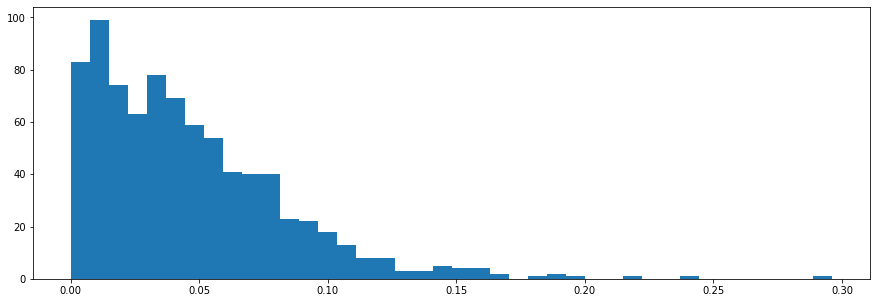

In [23]:
plt.hist(residuals, bins=40)

In [24]:
predictions=model.predict(augmentedTrainImages)

1995/1995 [==============================] - 21s 11ms/step


In [25]:
len(augmentedTrainImages)

63820

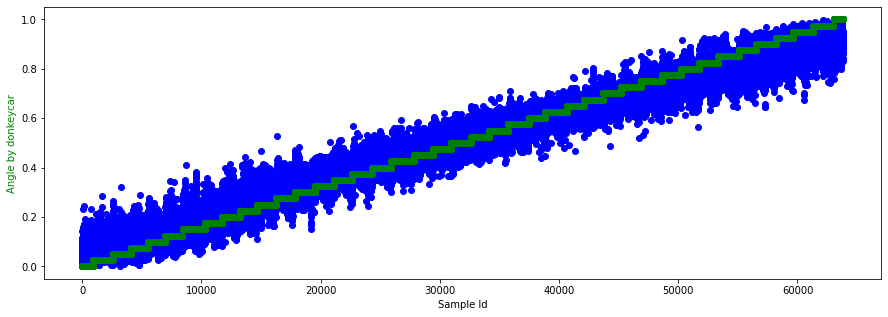

NameError: name 'show_statistics' is not defined

In [26]:


pwms2 = np.array(augmentedPwms[0:])
predictions2 = np.array(predictions[0:])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)


-1 delta:  0.2747398734092714 orig aug:  0.9500000000000002 pred:  0.6752601


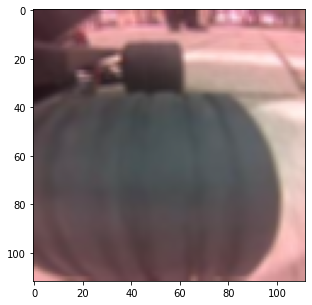

-2 delta:  0.2717300176620487 orig aug:  0.049999999999999656 pred:  0.32173002


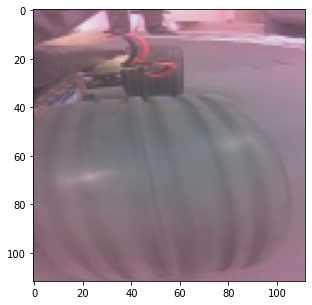

-3 delta:  0.2615824997425083 orig aug:  0.024999999999999634 pred:  0.2865825


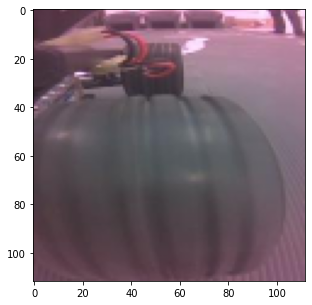

-4 delta:  0.260265386104584 orig aug:  0.14999999999999974 pred:  0.4102654


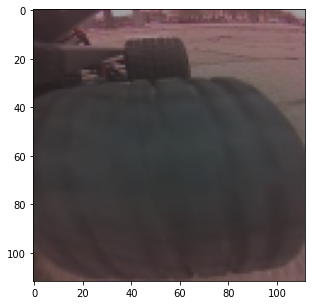

-5 delta:  0.25529451370239276 orig aug:  0.9500000000000002 pred:  0.6947055


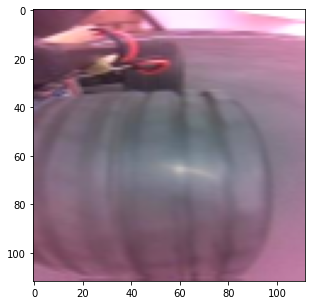

-6 delta:  0.25455393791198744 orig aug:  0.9000000000000001 pred:  0.64544606


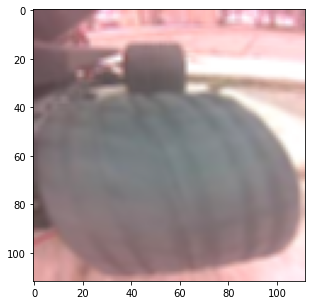

-7 delta:  0.254351043701172 orig aug:  0.9000000000000001 pred:  0.64564896


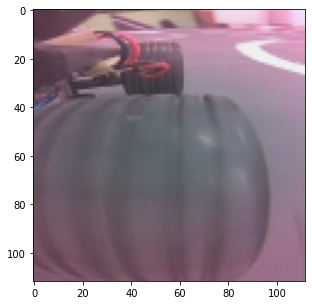

-8 delta:  0.25408515930175796 orig aug:  0.27499999999999986 pred:  0.52908516


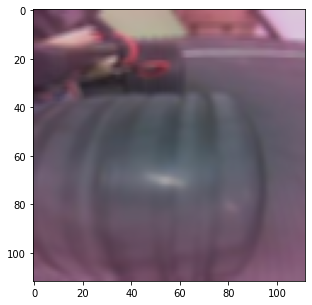

-9 delta:  0.24780882596969622 orig aug:  0.9500000000000002 pred:  0.7021912


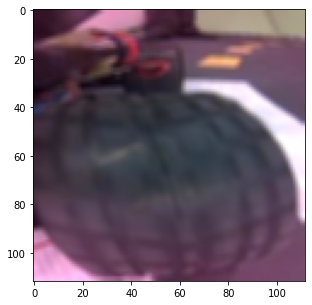

In [27]:
residuals2 = abs(predictions2.flatten() - augmentedPwms)

b = list(zip(residuals2, augmentedPwms, augmentedTrainImages, predictions2.flatten()))
res = sorted(b, key = lambda x: x[0])
residuals3, augmentedPwms3, augmentedTrainImages3, predictions3  = zip(*res)

for idx in range(1,10):

    print(-idx, 'delta: ',residuals3[-idx],'orig aug: ', augmentedPwms3[-idx], 'pred: ',predictions3[-idx])
    plt.imshow(augmentedTrainImages3[idx])
    plt.show()
    
    

In [41]:

residuals3[-1]

0.7374855160713198

In [28]:
def show_pwm_prediction(pwms, preditions, throttle, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, throttle, color="red")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle and Throttle by donkeycar', color="green")
    
    ax2 = ax.twinx()
    ax2.plot(idxs, preditions)
    ax2.set_ylabel('Angle by camera', color="blue")
    
    fig.set_figwidth(15)
    plt.show()

def show_pwm_prediction2(pwms, preditions, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, preditions, color="blue")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
def show_statistics(pwms, predictions, frames=None):

    #print('Sample count: ', len(predictions))
    #print('Cov', np.corrcoef([pwms,predictions]))    

    if frames == None:
        frames = len(predictions)
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    #sse = np.sum(((predictions3 - pwms)**2))
    sse = np.sum(((predictions - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

In [8]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-11-23 17:54:22.818577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
